# Evaluating the performance for each model

### Librairies

In [5]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [11]:
import math
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
import matplotlib.pylab as plt
import seaborn as sns

import dmba
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

%matplotlib inline

## Information for the evaluation :
DataFrame used to train/test and evaluate the model is "train_processed.csv". 

60 % should be used to train the model, and 40 % to test. Executing the first blocks of code will create these files, so you can use them in your model.

To evaluate the model, you should have this code in the same file as "train_processed.cssv" and also "submission.csv", which gaves the result of the model (rainfall) for test values.

Commentaires : 
- Split the data from train : for cross validation
- Correlation matrix
- ROC curves
- Lift gain
- Lift chart
- r2 score

Spliting the data into Train (60%) and Validation (40%)

In [62]:
# Load data frame and select columns for regression analysis
df = pd.read_csv('train_processed.csv')
outcome = 'rainfall'

# partition data
X = df.drop(columns=['rainfall'])
y = df['rainfall']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=42)

train_60percent_df = pd.concat([train_X, train_y], axis=1)
train_60percent_df.to_csv("train_60percent.csv", index=False)
test_X.to_csv("train_40percent.csv", index=False)

Typical evaluations

In [63]:
predictions = pd.read_csv('submission.csv')
predictions

,Id,Label
0,53.0,0.846154
1,680.0,0.615385
2,1254.0,1.000000
3,2131.0,0.846154
4,204.0,0.769231
...,...,...
1315,892.0,0.230769
1316,2132.0,0.923077
1317,308.0,0.692308
1318,384.0,0.846154


In [64]:
y_pred = predictions['Label']
y_pred

0       0.846154
1       0.615385
2       1.000000
3       0.846154
4       0.769231
          ...   
1315    0.230769
1316    0.923077
1317    0.692308
1318    0.846154
1319    0.076923
Name: Label, Length: 1320, dtype: float64

In [65]:
def Evaluate_Model(model_name):
    print(f"\n Model evaluated : {model_name}")
    
    #model tested's function which creates a sample_submission.csv with test_X as the dataset to verify
    predictions = pd.read_csv('submission.csv')
    y_pred = predictions['Label'] #result of the model

    print("Confusion matrix :")
    confusion_matrix_heatmap(test_y, y_pred)
    
    print("ROC curves :")
    plot_roc_curve(test_y, y_pred)
    
    print("Gain Chart & Lift Chart")
    Gain_Lift_Chart(test_y, y_pred)
    
    
    # Probabilités (si possible)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = None


    
    

In [31]:
def confusion_matrix_heatmap(y_true, y_pred):
    if any(isinstance(p, float) for p in y_pred):
        y_pred_copy = [1 if p >= 0.5 else 0 for p in y_pred]
    else:
        y_pred_copy = y_pred.copy()
    if any(isinstance(p, float) for p in y_true):
        y_true_copy = [1 if p >= 0.5 else 0 for p in y_true]
    else:
        y_true_copy = y_true.copy()

    classes = sorted(set(y_true_copy) | set(y_pred_copy))
    
    matrix = pd.DataFrame(
        data=0,
        index=[f"Real {cls}" for cls in classes],
        columns=[f"Predict {cls}" for cls in classes]
    )
    
    for true, pred in zip(y_true_copy, y_pred_copy):
        matrix.loc[f"Real {true}", f"Predict {pred}"] += 1

    plt.figure(figsize=(2, 2))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                linewidths=0.5, linecolor='gray')
    plt.title("Confusion matrix", fontsize=14)
    plt.xlabel("y_pred (predicted)")
    plt.ylabel("y_true (actual values)")
    plt.tight_layout()
    plt.show()
    
    accuracy = (matrix.iloc[1,1]+ matrix.iloc[0,0]) / matrix.values.sum()
    precision = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[0,1]) if (matrix.iloc[1,1] + matrix.iloc[0,1]) > 0 else 0
    recall = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[1,0]) if (matrix.iloc[1,1] + matrix.iloc[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nAccuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 score:  {f1:.2f}")

    return matrix

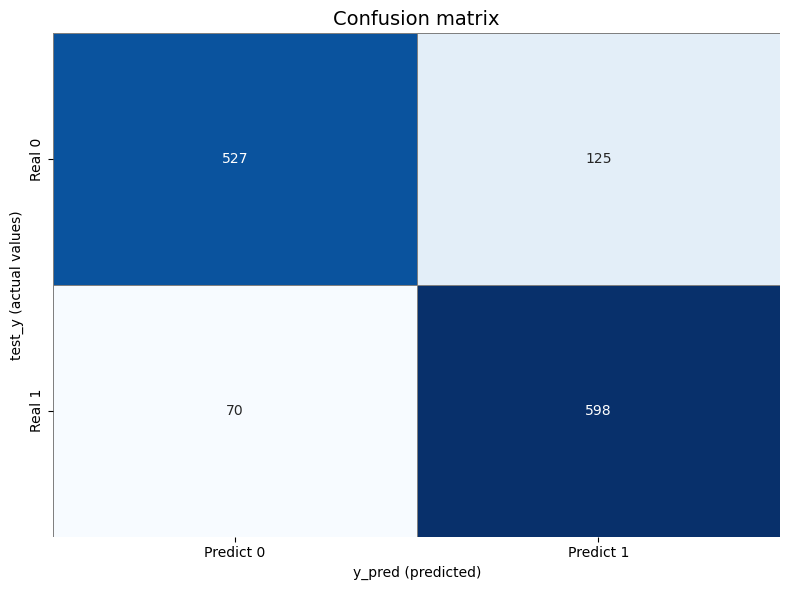


Accuracy:  0.85
Precision: 126.00
Recall:    71.00
F1 score:  90.82


,Predict 0,Predict 1
Real 0,527,125
Real 1,70,598


In [73]:
confusion_matrix_heatmap(test_y, y_pred)

In [20]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positives rate (FPR)')
    plt.ylabel('True positives rate (TPR)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

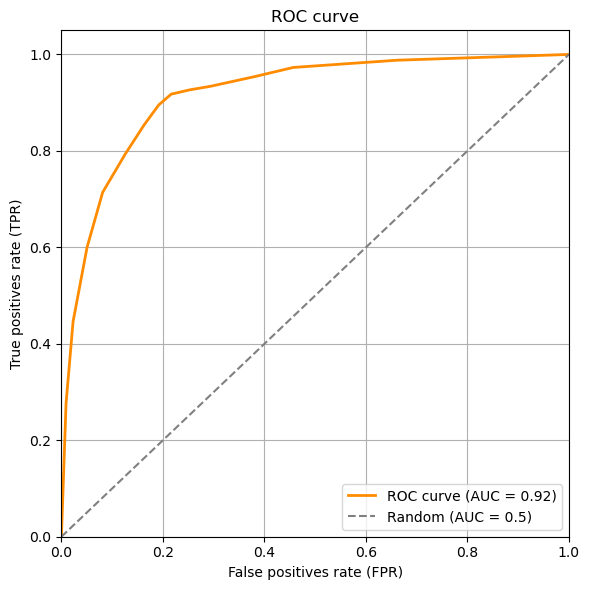

In [75]:
plot_roc_curve(test_y, y_pred)

In [27]:
def Gain_Lift_Chart(test_y, y_pred, n_bins=10):
    # sort the actual values in descending order of the prediction
    df = pd.DataFrame({'test_y': test_y, 'y_pred': y_pred})
    df = df.sort_values(by='y_pred', ascending=False).reset_index(drop=True)
    
    df['decile'] = pd.qcut(df.index, q=n_bins, labels=False)

    df['cumulative_positives'] = df['test_y'].cumsum()
    total_positives = df['test_y'].sum()
    df['gain'] = df['cumulative_positives'] / total_positives

    lift = []
    for i in range(n_bins):
        group = df[df['decile'] == i]
        if not group.empty:
            lift.append(group['test_y'].mean() / df['test_y'].mean())
        else:
            lift.append(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(np.linspace(0, 100, len(df)), df['gain'] * 100, label='Model')
    axs[0].plot([0, 100], [0, 100], '--', color='gray', label='Random')
    axs[0].set_title('Gains Chart')
    axs[0].set_xlabel('% Echantillon')
    axs[0].set_ylabel('% Positive')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].bar(range(1, n_bins + 1), lift)
    axs[1].set_title('Lift Chart')
    axs[1].set_xlabel('Decile (1 = top 10%)')
    axs[1].set_ylabel('Lift')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    
    # group the sorted predictions into 10 roughly equal groups and calculate the mean
    sorted_act_v = df['test_y']
    groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
    meanPercentile = sorted_act_v.groupby(groups).mean()
    meanResponse = meanPercentile / sorted_act_v.mean()
    meanResponse.index = (meanResponse.index + 1) * 10
    print('Lift based on meanResponse', meanResponse[10])
    random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
    cumPred10 = sorted_act_v.cumsum().iloc[-1]/10  # cumulative price based on model for top 10%
    print('Expected cumulative price for 10% random sales', random10)
    print('Lift calculated based on gains chart', cumPred10 / random10)
    
    print(f"Lift du premier décile (top 10%) : {lift[0]:.2f}")


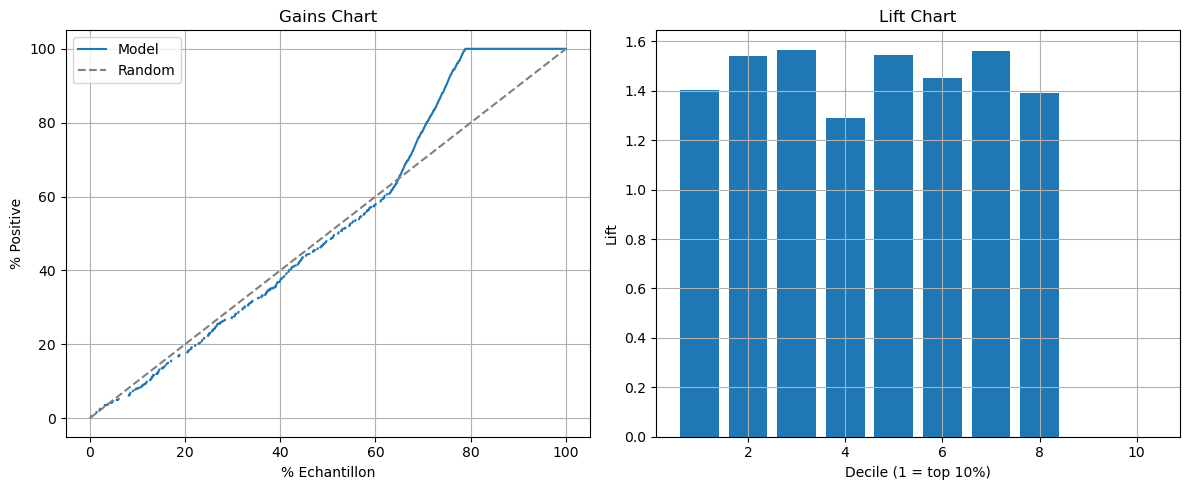

Lift based on meanResponse 1.4040340371887803
Expected cumulative price for 10% random sales 66.8
Cumulative price for top 10% sales nan
Lift calculated based on gains chart nan
Lift du premier décile (top 10%) : 1.40


In [89]:
Gain_Lift_Chart(test_y, y_pred)

Loop for testing other models (already implemented) :

In [ ]:
models = {
    "knn" : ;
    "log regression" : ;
    "decision tree" : ;
}

In [43]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#from imblearn import under_sampling, over_sampling
#from imblearn.over_sampling import SMOTE

In [47]:
train_df = pd.read_csv('kma_train.csv')
test_df = pd.read_csv('kma_test.csv')

X_train = train_df.drop(columns=['rainfall'])
y_train = train_df['rainfall']

X_test = test_df.copy().drop(columns=['rainfall'])
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)

y_proba = knn.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

In [48]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'rainfall': y_pred.astype(int)
})
submission_df.to_csv('kaggle1_submission.csv',sep = ',', index=False)
print(submission_df)
print(submission_df['rainfall'].value_counts())

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    print(f"k={k}, F1-score moyen: {scores.mean():.4f}")

      id  rainfall
0      0         0
1      1         0
2      2         0
3      3         0
4      4         1
..   ...       ...
150  150         0
151  151         0
152  152         0
153  153         0
154  154         0

[155 rows x 2 columns]
rainfall
0    116
1     39
Name: count, dtype: int64
k=1, F1-score moyen: 0.2343
k=2, F1-score moyen: 0.2346
k=3, F1-score moyen: 0.2350
k=4, F1-score moyen: 0.2350
k=5, F1-score moyen: 0.2347
k=6, F1-score moyen: 0.2167
k=7, F1-score moyen: 0.2164
k=8, F1-score moyen: 0.2162
k=9, F1-score moyen: 0.2161
k=10, F1-score moyen: 0.2166
k=11, F1-score moyen: 0.2162
k=12, F1-score moyen: 0.2166
k=13, F1-score moyen: 0.2164
k=14, F1-score moyen: 0.1480
k=15, F1-score moyen: 0.1484
k=16, F1-score moyen: 0.1475
k=17, F1-score moyen: 0.1474
k=18, F1-score moyen: 0.1476
k=19, F1-score moyen: 0.1477
k=20, F1-score moyen: 0.1478


## Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler


df_train = pd.read_csv('kma_train.csv')
df_test = pd.read_csv('kma_test.csv')

X_train = df_train.drop(columns=['id','rainfall'])
y_train = df_train['rainfall']
X_test = df_test.drop(columns=['id','rainfall'])
y_test = df_test['rainfall']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)


In [17]:
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'rainfall': y_pred
})

submission_df.to_csv('result_naibe_bayes.csv', index=False)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[97 19]
 [ 7 32]]
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88       116
         1.0       0.63      0.82      0.71        39

    accuracy                           0.83       155
   macro avg       0.78      0.83      0.80       155
weighted avg       0.86      0.83      0.84       155



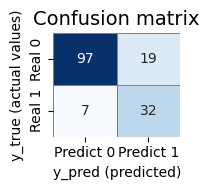


Accuracy:  0.83
Precision: 20.00
Recall:    8.00
F1 score:  11.43


,Predict 0,Predict 1
Real 0,97,19
Real 1,7,32


In [32]:
confusion_matrix_heatmap(y_test, y_pred)

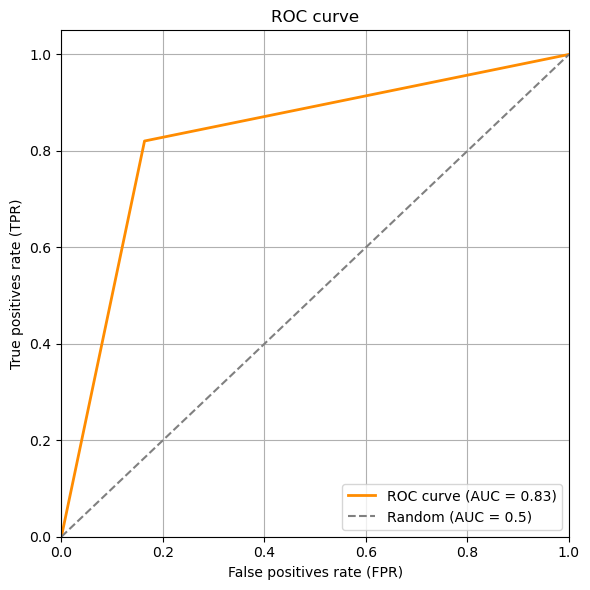

In [26]:
plot_roc_curve(y_test, y_pred)

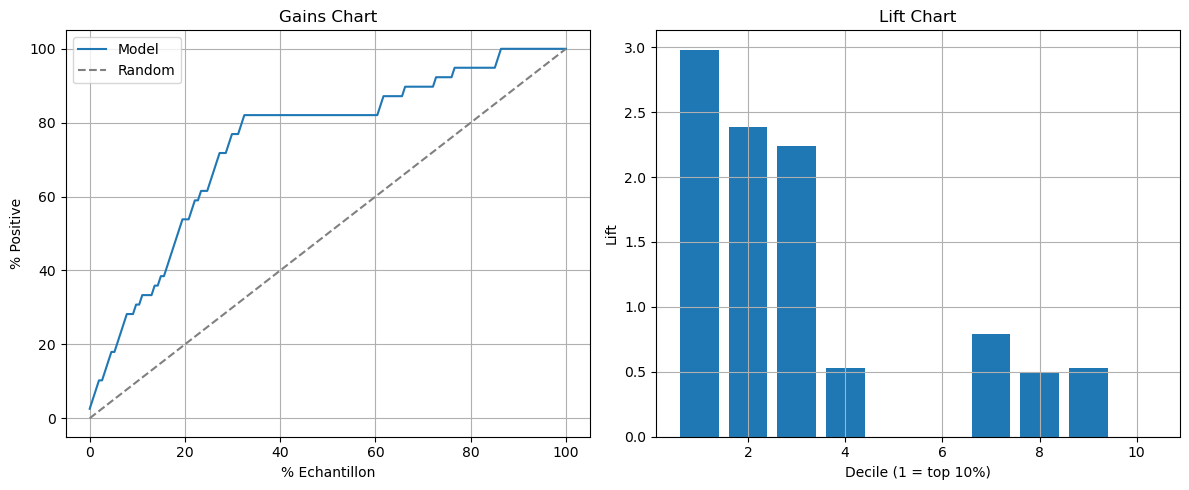

Lift based on meanResponse 2.980769230769231
Expected cumulative price for 10% random sales 3.9
Lift calculated based on gains chart 1.0
Lift du premier décile (top 10%) : 2.98


In [28]:
Gain_Lift_Chart(y_test, y_pred)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE on validation : {mse:.4f}")
print(f"RMSE on validation : {rmse:.4f}")
print(f"MAE on validation : {mae:.4f}")

MSE on validation : 0.1677
RMSE on validation : 0.4096
MAE on validation : 0.1677
